# Building a Retrieval-Augmented Generation (RAG) System

This notebook implements a Retrieval-Augmented Generation (RAG) system using:
- LangChain for document processing and vector operations
- FAISS for efficient similarity search
- Ollama for local LLM inference
- HuggingFace embeddings for text vectorization

We'll build a system that can answer questions about PDF documents by:
1. Loading and processing PDFs
2. Creating vector embeddings from the text
3. Performing similarity search for relevant content
4. Generating contextual answers using a local LLM

## 1. Setup Environment and Import Libraries

First, we need to install the required packages:

In [1]:
# # Install required packages
# %pip install langchain faiss-cpu pypdf2 ollama sentence-transformers

In [2]:
# %pip install -U langchain-community

In [3]:
# %pip install ipywidgets matplotlib

Now, let's import all the necessary libraries:

In [4]:
# Import necessary libraries
import os
import ollama
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from IPython.display import Markdown, display
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import time

## 2. PDF Loading and Text Extraction

We'll create a function to load PDF files and extract text from them:

In [5]:
def load_pdf(file_path):
    """
    Load a PDF file and extract text from it.
    
    Args:
        file_path (str): Path to the PDF file
        
    Returns:
        str: Extracted text from the PDF
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    with open(file_path, "rb") as file:
        reader = PdfReader(file)
        text = ""
        num_pages = len(reader.pages)
        
        print(f"Processing {num_pages} pages...")
        
        for i, page in enumerate(reader.pages):
            page_text = page.extract_text()
            text += page_text + "\n"
            # Print progress
            if (i+1) % 5 == 0 or i+1 == num_pages:
                print(f"Processed {i+1}/{num_pages} pages")
                
    print(f"Extracted {len(text)} characters of text.")
    return text

Let's test our PDF loading function with a sample PDF. For this example, we'll use the annual report PDF mentioned in the original code:

In [6]:
# Path to the PDF file
pdf_path = "../../annual-report-2024.pdf"

try:
    # Load and process PDF
    pdf_text = load_pdf(pdf_path)
    
    # Display a sample of the extracted text
    print("\nSample of extracted text (first 500 characters):")
    print("="*80)
    print(pdf_text[:500])
    print("="*80)
    print(f"Total text length: {len(pdf_text)} characters")
    
except FileNotFoundError:
    print(f"File not found: {pdf_path}")
    print("For this example, please place a PDF file at the specified path or update the path.")
    # Create a placeholder text for demonstration purposes
    pdf_text = "This is a sample text that simulates content from a PDF file. " * 100

Processing 5 pages...
Processed 5/5 pages
Extracted 10142 characters of text.

Sample of extracted text (first 500 characters):
Infosys Integrated Annual Report 2023-2456Dear Members,
The Board of Directors hereby submits the report of the business and operations of your Company (“the Company” or “Infosys”), along 
with the audited financial statements, for the financial year ended March 31, 2024. The consolidated performance of the Company and its subsidiaries has been referred to wherever required.
1. Results of our operations and state of affairs
(In ` crore, except per equity share data)
Particulars Standalone Consol
Total text length: 10142 characters


## 3. Text Chunking and Vector Store Creation

For effective retrieval, we need to split the text into manageable chunks and create embeddings:

In [7]:
def create_vector_store(text, chunk_size=1000, chunk_overlap=200):
    """
    Split text into chunks and create a vector store.
    
    Args:
        text (str): Text to process
        chunk_size (int): Size of each chunk
        chunk_overlap (int): Overlap between chunks
        
    Returns:
        FAISS: Vector store object
    """
    # Split text into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    
    start_time = time.time()
    chunks = text_splitter.split_text(text)
    chunking_time = time.time() - start_time
    
    print(f"Split text into {len(chunks)} chunks (took {chunking_time:.2f} seconds)")
    
    # Create embeddings
    print("Initializing embedding model...")
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2"
    )
    
    # Create vector store
    print("Creating vector store...")
    start_time = time.time()
    vector_store = FAISS.from_texts(chunks, embeddings)
    vectorization_time = time.time() - start_time
    
    print(f"Vector store created with {len(chunks)} vectors (took {vectorization_time:.2f} seconds)")
    
    return vector_store, chunks

Split text into 15 chunks (took 0.00 seconds)
Initializing embedding model...


/tmp/ipykernel_2348428/3841473336.py:28: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


Creating vector store...
Vector store created with 15 vectors (took 0.47 seconds)


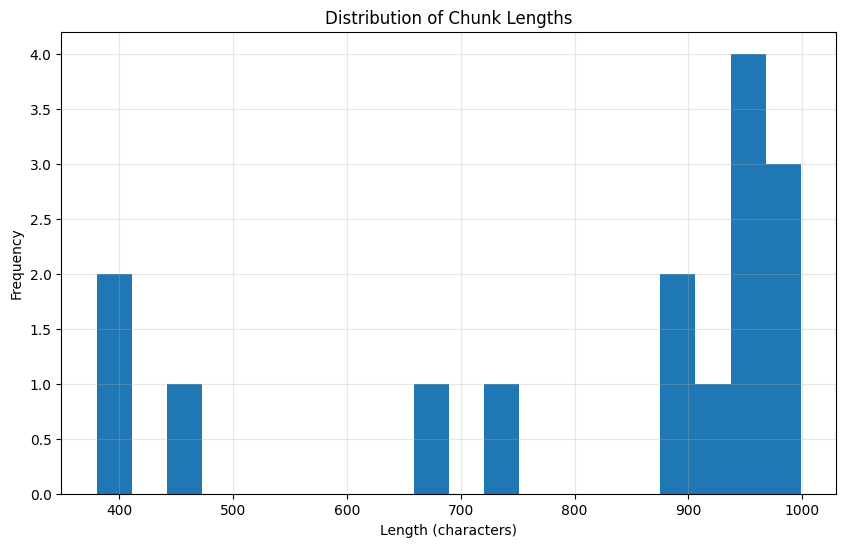

Average chunk length: 808.4 characters
Shortest chunk: 380 characters
Longest chunk: 999 characters


In [8]:
# Create vector store from the PDF text
vector_store, chunks = create_vector_store(pdf_text)

# Display some statistics about the chunks
chunk_lengths = [len(chunk) for chunk in chunks]

plt.figure(figsize=(10, 6))
plt.hist(chunk_lengths, bins=20)
plt.title('Distribution of Chunk Lengths')
plt.xlabel('Length (characters)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average chunk length: {np.mean(chunk_lengths):.1f} characters")
print(f"Shortest chunk: {min(chunk_lengths)} characters")
print(f"Longest chunk: {max(chunk_lengths)} characters")

Let's examine a few chunks to understand what our text looks like after chunking:

In [9]:
with open("chunk_preview.txt", "w", encoding="utf-8") as f:
    for chunk in chunks[:3]:
        f.write(chunk[:100] + "...\n\n")


In [10]:
# Display a few example chunks
for i in range(min(3, len(chunks))):
    print(f"Chunk {i+1} ({len(chunks[i])} characters):")
    print("-" * 50)
    print(chunks[i][:300] + "...")  # Show first 300 chars
    print("-" * 50)

Chunk 1 (931 characters):
--------------------------------------------------
Infosys Integrated Annual Report 2023-2456Dear Members,
The Board of Directors hereby submits the report of the business and operations of your Company (“the Company” or “Infosys”), along 
with the audited financial statements, for the financial year ended March 31, 2024. The consolidated performanc...
--------------------------------------------------
Chunk 2 (967 characters):
--------------------------------------------------
Total income 1,36,350 1, 27, 873 6.6 1,58,381 1,49,468 6.0
Expenses       
Cost of sales 89,032 85,762 3.8 1,07,413 1,02,353 4.9
Selling and marketing expenses 5,668 5,018 13.0 6,973 6,249 11.6
General and administration expenses 5,420 5,293 2.4 7, 537 7, 260 3.8
Total expenses 1,00,120 96,073 4.2 1...
--------------------------------------------------
Chunk 3 (734 characters):
--------------------------------------------------
Total comprehensive income for the year attributable to the

## 4. Question Answering with Ollama

Now, let's implement the question answering functionality using the Ollama API with the deepseek-r1 model:

In [18]:
def ask_ollama(query, context):
    """
    Generate an answer using Ollama API based on the provided context.
    
    Args:
        query (str): The user's question
        context (str): Context information retrieved from the vector store
        
    Returns:
        str: Generated answer from the model
    """
    prompt = f"""
    Answer the question based on the following context:

    Context:
    {context}

    Question: {query}
    
    Answer:
    """
    
    try:
        response = ollama.chat(
            model="deepseek-r1",
            messages=[{"role": "user", "content": prompt}]
        )
        
        return response['message']['content']
    except Exception as e:
        return f"Error generating response: {str(e)}"

In [19]:
def answer_question(query, vector_store, k=4):
    """
    Answer a question using RAG approach.
    
    Args:
        query (str): User's question
        vector_store: FAISS vector store
        k (int): Number of relevant chunks to retrieve
        
    Returns:
        str: Answer to the question
    """
    print(f"Searching for context relevant to: '{query}'")
    
    # Retrieve relevant chunks
    start_time = time.time()
    docs = vector_store.similarity_search(query, k=k)
    search_time = time.time() - start_time
    
    print(f"Retrieved {len(docs)} relevant chunks (took {search_time:.2f} seconds)")
    
    context = "\n\n".join([doc.page_content for doc in docs])
    context_length = len(context)
    
    print(f"Sending prompt with context of {context_length} characters to Ollama...")
    
    # Get answer from Ollama
    start_time = time.time()
    answer = ask_ollama(query, context)
    generation_time = time.time() - start_time
    
    print(f"Generated answer of {len(answer)} characters (took {generation_time:.2f} seconds)")
    
    return answer, docs

Let's test our question answering function with a sample question:

In [20]:
# Test with a sample question
sample_question = "What are the main financial highlights?"
answer, relevant_docs = answer_question(sample_question, vector_store)

print("\nQuestion:", sample_question)
print("\nAnswer:")
print("-" * 80)
print(answer)
print("-" * 80)

print("\nTop relevant context used:")
for i, doc in enumerate(relevant_docs[:2]):  # Show only first 2 contexts
    print(f"\nContext chunk {i+1}:")
    print("..." + doc.page_content[:300] + "...")  # First 300 chars

Searching for context relevant to: 'What are the main financial highlights?'
Retrieved 4 relevant chunks (took 0.02 seconds)
Sending prompt with context of 3703 characters to Ollama...
Generated answer of 3137 characters (took 8.95 seconds)

Question: What are the main financial highlights?

Answer:
--------------------------------------------------------------------------------
<think>
Okay, so I need to figure out the main financial highlights from the provided context. Let me read through the information carefully.

First, the context talks about investments made by Infosys, including various marketable securities like G-secs, CDs, CPs, mutual funds, etc., which shows they have a strong diversified investment portfolio with high credit ratings, indicating low liquidity risk. 

Then, looking at the financial data provided in tables, there are sections for total income, expenses, cost of sales, selling and marketing expenses, general and administrative expenses, profit before tax, tax

## 5. Interactive Demo

Let's create an interactive demo using IPython widgets:

In [21]:
def create_interactive_demo(vector_store):
    """Create an interactive demo for question answering"""
    
    # Create widgets
    question_input = widgets.Text(
        value='',
        description='Question:',
        placeholder='Type your question here...',
        layout=widgets.Layout(width='80%')
    )
    
    k_slider = widgets.IntSlider(
        value=4,
        min=1,
        max=10,
        step=1,
        description='Context chunks:',
        layout=widgets.Layout(width='50%')
    )
    
    output = widgets.Output()
    
    # Submit button
    button = widgets.Button(
        description='Get Answer',
        button_style='primary',
        tooltip='Click to get the answer',
        icon='search'
    )
    
    def on_button_clicked(_):
        with output:
            output.clear_output()
            if question_input.value.strip():
                print(f"Question: {question_input.value}")
                print("Generating answer...")
                answer, docs = answer_question(question_input.value, vector_store, k=k_slider.value)
                display(Markdown("### Answer:"))
                display(Markdown(answer))
                
                display(Markdown("### Sources:"))
                for i, doc in enumerate(docs):
                    display(Markdown(f"**Source {i+1}** (extract):\n> {doc.page_content[:150]}..."))
            else:
                print("Please enter a question.")
    
    button.on_click(on_button_clicked)
    
    # Layout
    return widgets.VBox([
        widgets.HTML("<h3>RAG Question Answering System</h3>"),
        widgets.HBox([question_input, button]),
        k_slider,
        output
    ])

In [22]:
# Create and display the interactive demo
demo = create_interactive_demo(vector_store)
display(demo)

## 6. Error Handling and Improvements

Let's enhance our system with better error handling and explore potential improvements:

In [23]:
class RAGSystem:
    """A more robust implementation of our RAG system with error handling"""
    
    def __init__(self, model_name="deepseek-r1", 
                 embeddings_model="sentence-transformers/all-MiniLM-L6-v2",
                 chunk_size=1000, chunk_overlap=200):
        self.model_name = model_name
        self.embeddings_model_name = embeddings_model
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.vector_store = None
        self.chunks = []
        self.pdf_text = ""
        
    def load_document(self, file_path):
        """Load document and handle errors"""
        try:
            if file_path.lower().endswith('.pdf'):
                self.pdf_text = load_pdf(file_path)
                return True, f"Successfully loaded PDF with {len(self.pdf_text)} characters"
            else:
                return False, "Only PDF files are currently supported"
        except FileNotFoundError:
            return False, f"File not found: {file_path}"
        except Exception as e:
            return False, f"Error loading document: {str(e)}"
    
    def process_document(self):
        """Process the loaded document and create vector store"""
        try:
            if not self.pdf_text:
                return False, "No document loaded. Please load a document first."
            
            self.vector_store, self.chunks = create_vector_store(
                self.pdf_text, self.chunk_size, self.chunk_overlap
            )
            return True, f"Successfully processed document into {len(self.chunks)} chunks"
        except Exception as e:
            return False, f"Error processing document: {str(e)}"
    
    def answer_query(self, query, k=4):
        """Answer a query with improved error handling"""
        try:
            if not self.vector_store:
                return False, "Vector store not initialized. Process a document first."
            
            if not query.strip():
                return False, "Query cannot be empty"
            
            answer, docs = answer_question(query, self.vector_store, k)
            return True, {"answer": answer, "sources": docs}
        except Exception as e:
            return False, f"Error answering query: {str(e)}"
    
    def suggest_improvements(self):
        """Suggest possible improvements to the RAG system"""
        improvements = [
            "**Implement document metadata** - Track source information for each chunk",
            "**Add document pre-processing** - Clean and normalize text before chunking",
            "**Experiment with different embedding models** - Try models like E5, BGE, or INSTRUCTOR",
            "**Implement re-ranking** - Use a cross-encoder to re-rank the retrieved chunks",
            "**Add chat history** - Maintain conversation context for follow-up questions",
            "**Optimize chunking strategy** - Try semantic chunking instead of character-based",
            "**Implement hybrid search** - Combine vector search with keyword-based search",
            "**Add evaluation metrics** - Measure relevance and answer quality"
        ]
        return improvements

In [24]:
# Create and test our improved RAG system
rag = RAGSystem()

# Show potential improvements
print("Potential improvements for the RAG system:")
for i, improvement in enumerate(rag.suggest_improvements(), 1):
    print(f"{i}. {improvement}")

Potential improvements for the RAG system:
1. **Implement document metadata** - Track source information for each chunk
2. **Add document pre-processing** - Clean and normalize text before chunking
3. **Experiment with different embedding models** - Try models like E5, BGE, or INSTRUCTOR
4. **Implement re-ranking** - Use a cross-encoder to re-rank the retrieved chunks
5. **Add chat history** - Maintain conversation context for follow-up questions
6. **Optimize chunking strategy** - Try semantic chunking instead of character-based
7. **Implement hybrid search** - Combine vector search with keyword-based search
8. **Add evaluation metrics** - Measure relevance and answer quality


### Summary and Conclusion

In this notebook, we've built a complete Retrieval-Augmented Generation (RAG) system that:

1. Loads and processes PDF documents
2. Chunks text and creates vector embeddings
3. Performs similarity search to find relevant context
4. Uses Ollama with the deepseek-r1 model to generate answers
5. Provides an interactive interface for querying the document

This implementation demonstrates the core components of a RAG system, but there are many ways to improve it further, as outlined in the improvements section.

Key takeaways:
- RAG enhances LLM responses with relevant context from specific documents
- The quality of chunking and embeddings directly impacts retrieval performance
- Local models like those in Ollama provide privacy and control advantages
- Error handling is crucial for production-ready RAG systems